In [147]:
import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import ndarray
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.nn as nn
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm
import os
from struct import unpack
import mlflow
import shap
import random

# 1. Read MNIST from the disk

In [148]:
def read_images(filename):
    with open(filename, 'rb') as f:
        magic, num_images = unpack('>II', f.read(8))
        num_rows, num_cols = unpack('>II', f.read(8))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)
    return images

def read_labels(filename):
    with open(filename, 'rb') as f:
        # both not needed for the kaggleton
        magic, num_labels = unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels


path = 'D:/IT/Data_science/lessons/kaggle 7/digit-recognition/input'

train_images = read_images(os.path.join(path, 'train-images.idx3-ubyte'))
train_labels = read_labels(os.path.join(path, 'train-labels.idx1-ubyte'))

test_images = read_images(os.path.join(path, 't10k-images.idx3-ubyte'))
test_labels = read_labels(os.path.join(path, 't10k-labels.idx1-ubyte'))

print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")

Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


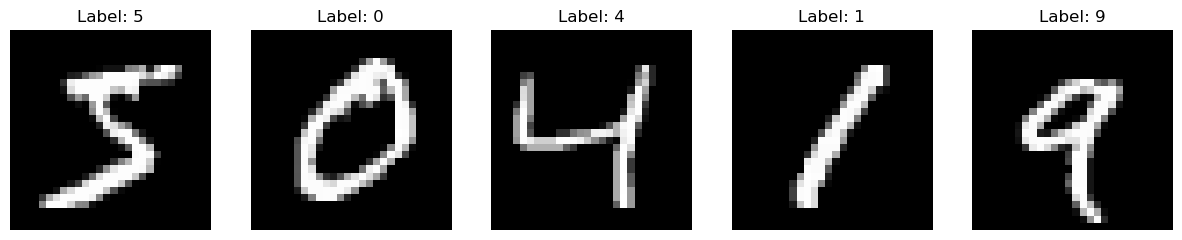

In [149]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

for i, ax in enumerate(axes):
    ax.imshow(train_images[i], cmap='gray')
    ax.title.set_text(f'Label: {train_labels[i]}')
    ax.axis('off')
plt.show()

In [150]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [151]:
class MNISTDataset(Dataset):
    """MNIST dataset."""
    
    def __init__(self, images: ndarray, labels: ndarray, transform=None):
        """
        Args:
            images (numpy.ndarray): Images data.
            labels (numpy.ndarray): Labels data.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 2. Normalization

In [152]:
def normalize(data):
    return (data / 255)

train_images = normalize(train_images)
test_images = normalize(test_images)

# 3. Datasets and Dataloaders

In [153]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert a numpy.ndarray to PIL Image.
    transforms.ToTensor(),  # Converts a PIL Image to a tensor.
])

# Train
train_dataset = MNISTDataset(images=train_images,
                             labels=train_labels,
                             transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, drop_last=True, shuffle=True)

# Test
test_dataset = MNISTDataset(images=test_images,
                            labels=test_labels,
                            transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

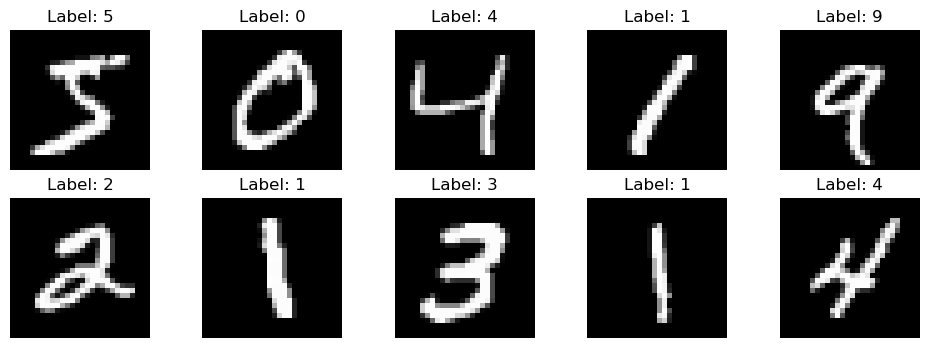

In [154]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))

k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(train_images[k], cmap='gray')
        ax[i, j].title.set_text(f'Label: {train_labels[k]}')
        ax[i, j].axis('off')
        k+=1
plt.show()

In [155]:
# Example of iterating over DataLoader
for images, labels in train_loader:
    print(f'Batch images shape: {images.shape}')
    print(f'Batch labels shape: {labels.shape}')
    break  # Example stops after the first batch

Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


In [156]:
# Example of iterating over DataLoader
for _images, _labels in test_loader:
    print(f'Batch images shape: {_images.shape}')
    print(f'Batch labels shape: {_labels.shape}')
    break  # Example stops after the first batch

Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


# 4. CNN

# Architecture

In [157]:
class DigitRecognition(nn.Module):
    def __init__(self, num_classes):
        super(DigitRecognition, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=(3,3),
                               padding=2)

        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=(4,4),
                               padding=1)

        self.pool = nn.MaxPool2d(kernel_size=(2,2))

        self.linear = nn.Linear(64*7*7, num_classes)
    
    def forward(self, x):
        #print("Input shape:", x.shape)
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = self.linear(x)
        #print("Output shape:", x.shape)
        return x

# Parameters

In [170]:
device = 'cpu'
num_classes = 10 # ten numbers from 0 to 9
model = DigitRecognition(num_classes=num_classes).to(device)

n_epoch = 4
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Epoch4/4, Train loss:0.0296, Test loss: 0.0341: 100%|██████████| 4/4 [07:16<00:00, 109.23s/it]


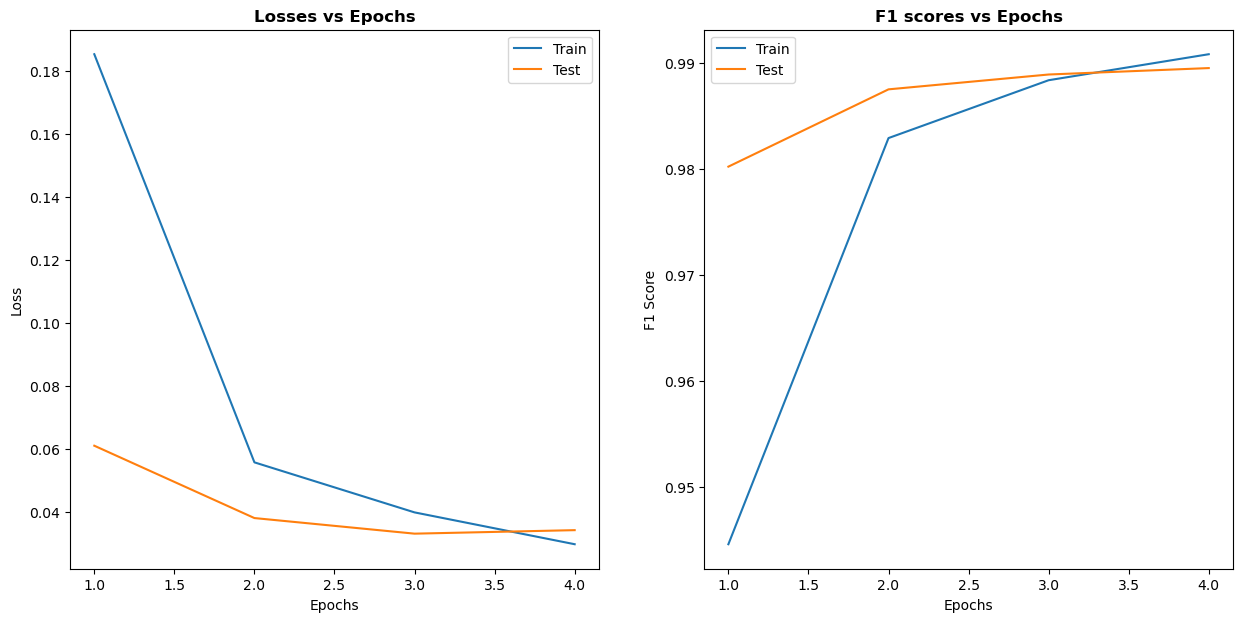

Train Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5922
           1       0.99      1.00      0.99      6737
           2       0.99      0.99      0.99      5954
           3       0.99      0.99      0.99      6129
           4       0.99      0.99      0.99      5839
           5       0.99      0.99      0.99      5417
           6       0.99      0.99      0.99      5911
           7       0.99      0.99      0.99      6262
           8       0.99      0.99      0.99      5850
           9       0.99      0.99      0.99      5947

    accuracy                           0.99     59968
   macro avg       0.99      0.99      0.99     59968
weighted avg       0.99      0.99      0.99     59968

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.

In [171]:
mlflow.set_experiment('MNIST')
mlflow.set_tracking_uri("file://D:/IT/Data_science/lessons/kaggle 7/mlruns")

with mlflow.start_run(run_name='Final params'):
    hyperparams = {
        'n_epoch': 4,
        'learning_rate': 0.001,
        'conv1_out_channels': 32,
        'conv2_out_channels': 64,
        'conv1_kernel_size': (3, 3),
        'conv2_kernel_size': (4, 4),
        'pool_kernel_size': (2, 2),
        'padding_conv1': 2,
        'padding_conv2': 1,
        'linear_input_size': 64 * 7 * 7,
    }
    
    mlflow.log_params(hyperparams)

    pbar = tqdm(range(n_epoch))

    # dictionaries for recording loss values
    train_losses = []
    test_losses = []

    train_f1_scores = []
    test_f1_scores = []
    train_reports = []
    test_reports = []


    for epoch in pbar:
        #train mode
        model.train()
        running_train_loss = 0
        
        # dictionaries for recording predictions and targets for further f1 evaluation
        train_predictions = []
        train_targets = []

        # iterate through train loader
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device) # send them to the device

            optimizer.zero_grad() # zero grads
            outputs = model(images) # outputs

            train_loss = criterion(outputs, labels) # train loss
            train_loss.backward() # count gradients

            optimizer.step() # apply gradients

            running_train_loss += train_loss.item()

            # add train predictions and targets to dictionaries
            train_predictions.extend(outputs.argmax(dim=1).detach().numpy())
            train_targets.extend(labels.detach().numpy())

        avg_train_loss = running_train_loss / len(train_loader) # average train loss per epoch
        train_losses.append(avg_train_loss)

        # calculate f1 and classification report
        train_f1 = f1_score(train_targets, train_predictions, average='weighted', zero_division='warn')
        train_report = classification_report(train_targets, train_predictions, zero_division='warn')

        # add values to the dictionaries
        train_f1_scores.append(train_f1)
        train_reports.append(train_report)
        

        # eval mode
        model.eval()
        running_test_loss = 0

        # dictionaries for recording predictions and targets for further f1 evaluation
        test_predictions = []
        test_targets = []

        with torch.no_grad():
            # iterate through test loader
            for _i, (_images, _labels) in enumerate(test_loader):
                _images, _labels = _images.to(device), _labels.to(device) # send them to the device

                outputs = model(_images) # outputs
                test_loss = criterion(outputs, _labels) # test loss

                running_test_loss += test_loss.item()

                # add test predictions and targets to dictionaries
                test_predictions.extend(outputs.argmax(dim=1).detach().numpy())
                test_targets.extend(_labels.detach().numpy())

            avg_test_loss = running_test_loss / len(test_loader) # average test loss per epoch
            test_losses.append(avg_test_loss)

            # calculate f1 and classification report
            test_f1 = f1_score(test_targets, test_predictions, average='weighted', zero_division='warn')
            test_report = classification_report(test_targets, test_predictions, zero_division='warn')

            # add values to the dictionaries
            test_f1_scores.append(test_f1)
            test_reports.append(test_report)

            
        pbar.set_description(f"Epoch{epoch+1}/{n_epoch}, Train loss:{avg_train_loss:.4f}, Test loss: {avg_test_loss:.4f}")

    mlflow.log_metric("train_loss", train_losses[-1])
    mlflow.log_metric("test_loss", test_losses[-1])
    mlflow.log_metric("train_f1_score", train_f1_scores[-1])
    mlflow.log_metric("test_f1_score", test_f1_scores[-1])

    mlflow.end_run()

plt.figure(figsize=(15, 7))
# Plot learning curve
plt.subplot(1, 2, 1) 
plt.plot(range(1, n_epoch+1), train_losses, label='Train')
plt.plot(range(1, n_epoch+1),test_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses vs Epochs', fontweight='bold')
plt.legend()

# Plot f1 
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epoch+1), train_f1_scores, label='Train')
plt.plot(range(1, n_epoch+1), test_f1_scores, label='Test')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 scores vs Epochs', fontweight='bold')
plt.legend()

plt.show()

print("Train Classification Report:")
print(train_reports[-1])
    
print("Test Classification Report:")
print(test_reports[-1])

In [173]:
test_f1_scores[-1]

0.9895040539190298

# Visualize the model's predictions

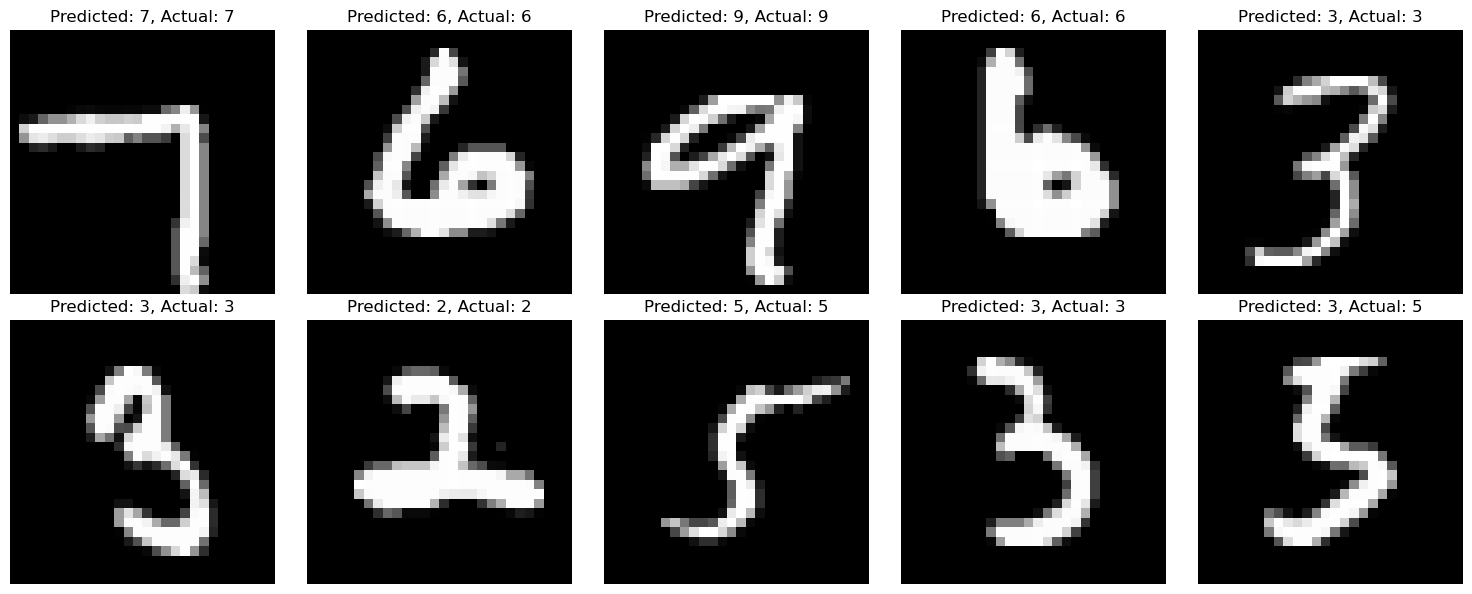

In [174]:
# Choose some random images from the test set
num_rows = 2
num_cols = 5
random_indices = np.random.choice(len(test_dataset), num_rows * num_cols)

# Set the model to evaluation mode
model.eval()

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# Iterate over the random indices
for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    image, label = test_dataset[idx]
    image = image.unsqueeze(0).to(device) # Add a batch dimension and send to device
    prediction = model(image).argmax(dim=1).item() # Get model prediction
    axes[row, col].imshow(image.squeeze().cpu().numpy(), cmap='gray') # Show the image
    axes[row, col].set_title(f"Predicted: {prediction}, Actual: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

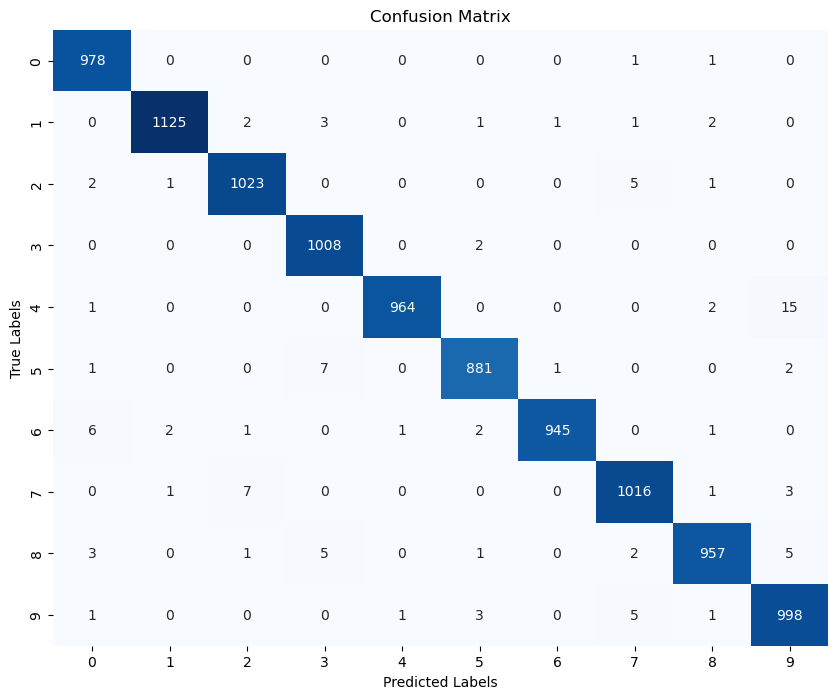

In [198]:
# Set the model to evaluation mode
model.eval()

# Create lists to store predictions and ground truth labels
all_predictions = []
all_targets = []

# Iterate over the test dataset to get predictions and ground truth labels
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predictions = outputs.argmax(dim=1).cpu().numpy()
    all_predictions.extend(predictions)
    all_targets.extend(labels.cpu().numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()